# Process EgoHands dataset

Use part of the ["EgoHands: A Dataset for Hands in Complex Egocentric Interactions"](http://vision.soic.indiana.edu/projects/egohands/) dataset.

_"The EgoHands dataset contains 48 Google Glass videos of complex, first-person interactions between two people."_ This dataset contains mainly of segmentation masks we can convert into bounding boxes. 

This notebook will download the EgoHands dataset, sample some examples and save results in a standardised way that we can use later.

Download the data from http://vision.soic.indiana.edu/egohands_files/egohands_data.zip into `./downloads/` and extract the .zip file before running this notebook.

Data will be saved as csv with 2 columns:

* `path`: absolute path to image
* `boxes`: Boxes as json string. `[(ymin, xmin, ymax, ymax) ...]`

In [1]:
import os
import sys
import pathlib
import pandas as pd
import json

import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy
import scipy.io
from sklearn.model_selection import train_test_split

from IPython.display import display

np.random.seed(seed=42)

In [2]:
DOWNLOAD_DIR = './downloads/'
DATASET_PATH = os.path.join(DOWNLOAD_DIR, '_LABELLED_SAMPLES')
TRAINING_FILE = 'train_files.csv'
TESTING_FILE = 'test_files.csv'

In [3]:
# Get all directories with samples
sample_directories = [f for f in pathlib.Path(DATASET_PATH).iterdir() if f.is_dir()]
print('{} folders found.'.format(len(sample_directories)))

48 folders found.


In [4]:
def load_polygons(directory):
    """
    Load polygons from polygons.mat file.
    
    Args:
        (Path): pathlib Path object of directory to load samples from.
        
    Returns 
    """
    # Load polygons file
    annotation_path = directory.joinpath('polygons.mat')
    mat = scipy.io.loadmat(annotation_path.resolve())
    # Load polygons data structure
    polygons = mat['polygons'][0]
    images_boxes = [
        get_boxes(polygons, frame_idx) for frame_idx in range(polygons.shape[0])
    ]
    return images_boxes
    

def get_boxes(polygons, frame_idx):
    """
    Get all bounding boxes belonging to a single image.
    
    Args:
        polygons (ndarray): Numpy array containing bounding boxes for each image in a directory
            extracted from .mat file struct. Image bounding boxes should follow image order.
        frame_idx (int): Index of image in folder (when sorted alphabetically).
        
    Returns:
        [(float, float, float, float)] List of bounding boxes belonging to a sigle image.
        Bounding box is represented as (ymin, xmin, ymax, ymax).
    """
    frame_polygons = polygons[frame_idx]
    boxes_list = []
    i = 0
    while True:
        try:
            poly = frame_polygons[i]
        except IndexError:
            break
        if poly.shape[1] == 2:
            xs, ys = zip(*[(int(poly[ci][0]), int(poly[ci][1])) for ci in range(poly.shape[0])])
            boxes_list.append((min(ys), min(xs), max(ys), max(xs)))
        i += 1
    return boxes_list

In [5]:
# Get all samples for each directory
def get_path_boxes(directory):
    """
    Get path and boxes represented as string.
    
    Args:
        directory (Path): pathlib Path object of directory to load samples from.
        
    Returns:
        [(str, str)]. List of tuple of (path, boxes as json)
    """
    images_boxes = load_polygons(directory)
    return [
        (path.absolute(), json.dumps(boxes_list)) for boxes_list, path 
        in zip(images_boxes, sorted(directory.glob('*.jpg'))) if boxes_list]


def add_to_train_test(directory, df_train, df_test):
    """
    Add path and boxes to the training and testing dataframes.
    
    Args:
        directory (Path): pathlib Path object of directory to load samples from.
        df_files_boxes (DataFrame): Pandas dataframe to save path and boxes to.
    """
    data = get_path_boxes(directory)
    df_data = pd.DataFrame.from_records(data, columns=['path', 'boxes'])
    df_data_train, df_data_test = train_test_split(
        df_data, shuffle=False, test_size=0.1, random_state=42)
    df_train = pd.concat([df_train, df_data_train], ignore_index=True)
    df_test = pd.concat([df_test, df_data_test], ignore_index=True)
    return df_train, df_test


# Create empty dataframe
df_train = pd.DataFrame({'path' : [], 'boxes':[]}, columns=['path', 'boxes'])
df_test = pd.DataFrame({'path' : [], 'boxes':[]}, columns=['path', 'boxes'])
# Add samples each directory to the dataframes
for directory in sample_directories:
    df_train, df_test  = add_to_train_test(directory, df_train, df_test)

# Save dataframe
df_train.to_csv(TRAINING_FILE)
df_test.to_csv(TESTING_FILE)

In [6]:
# Display some samples
print('Training data:')
with pd.option_context('display.max_rows', 5, 'display.max_columns', 3):
    display(df_train)

print('Test data:')
with pd.option_context('display.max_rows', 5, 'display.max_columns', 3):
    display(df_test)

Training data:


,path,boxes
0,/Users/42155/Workspace/tensorflow_experiments/...,"[[679, 753, 718, 806], [229, 691, 328, 807], [..."
1,/Users/42155/Workspace/tensorflow_experiments/...,"[[675, 740, 718, 803], [365, 649, 534, 816], [..."
...,...,...
4305,/Users/42155/Workspace/tensorflow_experiments/...,"[[349, 138, 692, 484], [328, 527, 584, 870], [..."
4306,/Users/42155/Workspace/tensorflow_experiments/...,"[[345, 104, 605, 477], [340, 431, 712, 777], [..."


Test data:


,path,boxes
0,/Users/42155/Workspace/tensorflow_experiments/...,"[[419, 825, 718, 1042], [297, 734, 396, 849], ..."
1,/Users/42155/Workspace/tensorflow_experiments/...,"[[617, 769, 718, 994], [299, 654, 391, 761], [..."
...,...,...
478,/Users/42155/Workspace/tensorflow_experiments/...,"[[491, 102, 718, 427], [446, 674, 717, 868], [..."
479,/Users/42155/Workspace/tensorflow_experiments/...,"[[489, 86, 716, 400], [436, 664, 716, 845], [5..."


## Visualise some of the images and boxes

In [7]:
df_files_boxes = pd.read_csv(TRAINING_FILE, header=0, index_col=0)

# Display some samples
with pd.option_context('display.max_rows', 5, 'display.max_columns', 3):
    display(df_files_boxes)

,path,boxes
0,/Users/42155/Workspace/tensorflow_experiments/...,"[[679, 753, 718, 806], [229, 691, 328, 807], [..."
1,/Users/42155/Workspace/tensorflow_experiments/...,"[[675, 740, 718, 803], [365, 649, 534, 816], [..."
...,...,...
4305,/Users/42155/Workspace/tensorflow_experiments/...,"[[349, 138, 692, 484], [328, 527, 584, 870], [..."
4306,/Users/42155/Workspace/tensorflow_experiments/...,"[[345, 104, 605, 477], [340, 431, 712, 777], [..."


/Users/42155/Workspace/tensorflow_experiments/input_data/downloads/egohands_data/_LABELLED_SAMPLES/CARDS_OFFICE_H_T/frame_1434.jpg


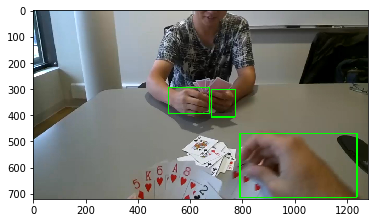

/Users/42155/Workspace/tensorflow_experiments/input_data/downloads/egohands_data/_LABELLED_SAMPLES/JENGA_LIVINGROOM_H_B/frame_0189.jpg


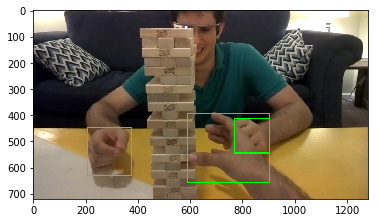

/Users/42155/Workspace/tensorflow_experiments/input_data/downloads/egohands_data/_LABELLED_SAMPLES/CHESS_COURTYARD_S_H/frame_0575.jpg


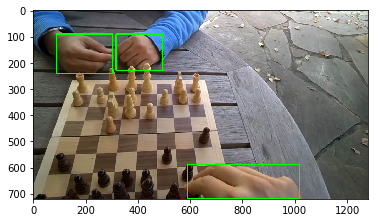

/Users/42155/Workspace/tensorflow_experiments/input_data/downloads/egohands_data/_LABELLED_SAMPLES/CHESS_LIVINGROOM_H_T/frame_1563.jpg


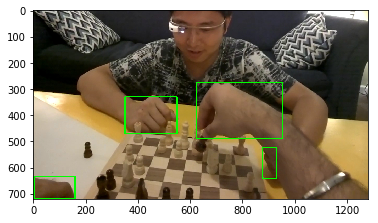

/Users/42155/Workspace/tensorflow_experiments/input_data/downloads/egohands_data/_LABELLED_SAMPLES/PUZZLE_COURTYARD_B_S/frame_1239.jpg


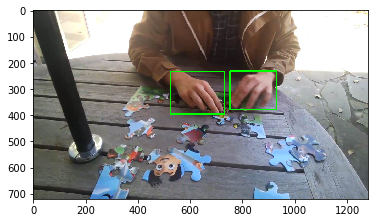

In [8]:
for _, row in df_files_boxes.sample(n=5).iterrows():
    # Load path and boxes
    path = row['path']
    boxes_list = json.loads(row['boxes'])
    # Visualise boxes
    print(path)
    img = cv2.imread(path)
    for (ymin, xmin, ymax, xmax) in boxes_list:
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 3) 
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()